In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import rosbag
import glob
import os
import rospy
import bagpy
from bagpy import bagreader

In [2]:
data_path = './Robot_ViconOctober/'

In [3]:
# Extract stationary data

## Load Vicon data
vicobags_stat = glob.glob(data_path+'ViconStationeryDataOct/*.bag')
    
for i,bag in enumerate(vicobags_stat): # loop over vicon bags
    vsbag = rosbag.Bag(bag)
    vicon_statXpos = []
    vicon_statYpos = []
    vicon_statZpos = []
    for topicc, msgg, tt in vsbag.read_messages(topics=['/vicon/packbot_endEff/packbot_endEff']): # extract data
        vicon_statXpos.append(msgg.transform.translation.x)
        vicon_statYpos.append(msgg.transform.translation.y)
        vicon_statZpos.append(msgg.transform.translation.z)  
    vsbag.close()

    vicon_statXPosArr = np.array(vicon_statXpos)
    vicon_statYPosArr = np.array(vicon_statYpos)
    vicon_statZPosArr = np.array(vicon_statZpos)
    vicon_statPosArr = np.column_stack((vicon_statXPosArr,vicon_statYPosArr,vicon_statZPosArr)) 

    np.save(data_path+'vicon_statPosArr_%d.npy'%i, vicon_statPosArr) # save to numpy

# Load Robot data    
robobags_stat = glob.glob(data_path+'RobotStationeryDataOct/*.bag')
for i,bag in enumerate(robobags_stat): # loop over robot bags
    rsbag = rosbag.Bag(bag)
    robot_statXpos = []
    robot_statYpos = []
    robot_statZpos = []
    for topi, msgs, tym in rsbag.read_messages(topics=['/tag_detections']): # extract data
        try:
            robot_statXpos.append(msgs.detections[0].pose.pose.pose.position.x)
            robot_statYpos.append(msgs.detections[0].pose.pose.pose.position.y)
            robot_statZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
        except:
            continue
    rsbag.close()
    robot_statXposArr = np.array(robot_statXpos)
    robot_statYposArr = np.array(robot_statYpos)
    robot_statZposArr = np.array(robot_statZpos)
    robot_statposArr = np.column_stack((robot_statXposArr,robot_statYposArr,robot_statZposArr))
    np.save(data_path+'robot_statPosArr_%d.npy'%i, robot_statposArr)

In [4]:
# Create procrustes function to use later
def procrustes(matx1,matx2):

    # translate all the data to the origin
    mean1 =  np.mean(matx1, 0)
    mean2 =  np.mean(matx2, 0)
    matx1 -= mean1
    matx2 -= mean2

    norm1 = np.linalg.norm(matx1)
    norm2 = np.linalg.norm(matx2)

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    matx1 /= norm1
    matx2 /= norm2

    L,D,M = np.linalg.svd(matx1.T.dot(matx2))
    
    s = np.sum(D)*norm1/norm2

    Rot = L.dot(M)
    tra = mean1 - (s*np.dot(Rot,mean2.T)).T

    return Rot, tra.reshape(-1,1), s

In [5]:
# Sanity check loading data we just saved
vicon_list = []
robot_list = []
for i in range(len(vicobags_stat)):
    vicon = np.load(data_path+'vicon_statPosArr_%d.npy'%i)
    vicon_list.append(vicon)
    
    robot = np.load(data_path+'robot_statPosArr_%d.npy'%i)
    robot_list.append(robot)

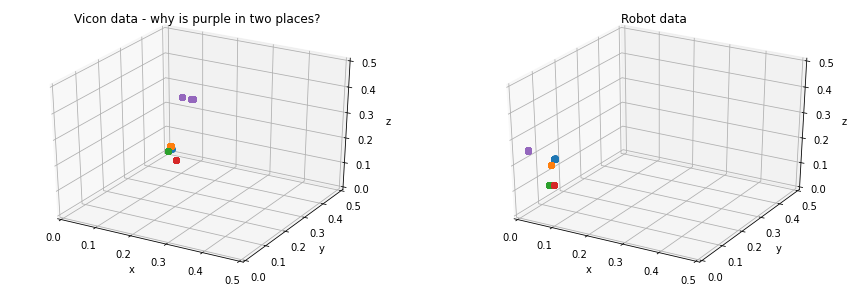

In [6]:
# Plot data we just loaded
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
for i in range(5):
    
    ax0.plot(vicon_list[i][:,0],vicon_list[i][:,1],vicon_list[i][:,2],'o')
    ax1.plot(robot_list[i][:,0],robot_list[i][:,1],robot_list[i][:,2],'o')
    
ax0.set_xlim(0,0.5)
ax0.set_ylim(0,0.5)
ax0.set_zlim(0,0.5)
ax0.set_ylabel('y')
ax0.set_xlabel('x')
ax0.set_zlabel('z')
ax0.set_title('Vicon data - why is purple in two places?')

ax1.set_xlim(0,0.5)
ax1.set_ylim(0,0.5)
ax1.set_zlim(0,0.5)
ax1.set_title('Robot data')
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_zlabel('z')

plt.show()

In [7]:
# Get means 
vicon_means = [np.mean(d,axis=0) for d in vicon_list]
robot_means = [np.mean(d,axis=0) for d in robot_list]

Rot, trans,scale = procrustes(np.array(vicon_means),np.array(robot_means))
print(Rot)
print(trans)
print(scale) # should be close to 1 for good data

# Save calibration parameters for use in dynamics analysis

np.save(data_path+'Rot.npy',Rot)
np.save(data_path+'trans.npy',trans)
np.save(data_path+'scale.npy',scale)

# Rotate Robot data into Vicon frame of reference
robot_v_list = [scale*np.dot(Rot,d.T).T + trans.T for d in robot_list]

[[-0.94471729  0.18102871  0.27338224]
 [-0.28272685 -0.87200987 -0.39958017]
 [ 0.16605653 -0.45478279  0.87498448]]
[[0.39983824]
 [0.0546991 ]
 [0.18974951]]
1.0847180873509459


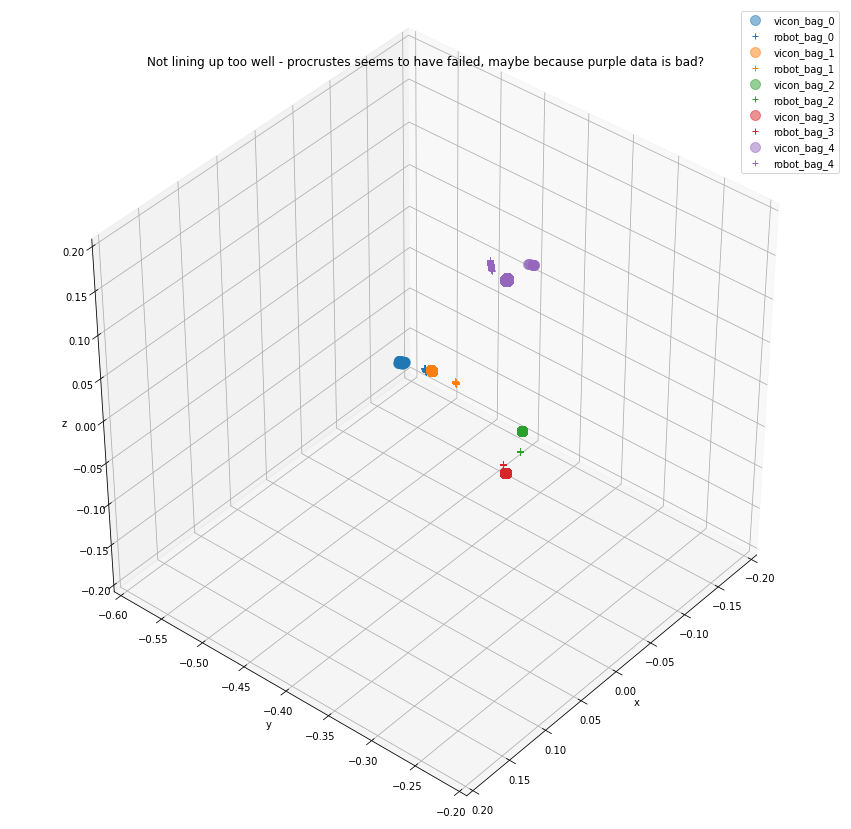

In [8]:
# Plot rotates data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for i in range(5):
    
    ax.plot(vicon_list[i][:,0],vicon_list[i][:,1],vicon_list[i][:,2],'o',color='C%d'%i,alpha=0.5,markersize=10,label='vicon_bag_%d'%i)
    ax.plot(robot_v_list[i][:,0],robot_v_list[i][:,1],robot_v_list[i][:,2],'+',color='C%d'%i,label='robot_bag_%d'%i)
    
ax.set_xlim(-0.2,0.2) # set limits, making sure axis scale is the same - 0.4 between all
ax.set_ylim(-0.6,-0.2)
ax.set_zlim(-0.2,0.2)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

ax.set_title('Not lining up too well - procrustes seems to have failed, maybe because purple data is bad?')

ax.legend()

ax.view_init(elev=40., azim=40) # Change viewing angle to see better

plt.show()